In [ ]:
import math
import numpy as np

import colorsys
from matplotlib import pyplot as plt
from matplotlib import cm, colors, colorbar

from tqdm import tqdm

import cv2

from sklearn.preprocessing import normalize 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

import pickle
from sklearn.cluster import OPTICS, cluster_optics_dbscan

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
way = '/content/drive/My Drive/Colab Notebooks/' # путь для сохранения обрабатываемых массивов и моделей

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


##Методы подробно

###**Поле всех амплитуд**

*Взять иную комбинацию наборов данных для упрощения?*






In [ ]:
def visualize_ampField(ampField, ind):
# визуализирует первые 1000 трасс набора данных с номером ind (разные сейсмические данные)

    if (ind > ampField.shape[0] - 1):
        print('There is no dataset with this number')
    current_ampField = ampField[ind]
    
    rows = current_ampField[:1000].shape[0]
    cols = current_ampField[:1000].shape[1]
    fig, axes = plt.subplots(1, 1, figsize=(rows/30, cols/30))
    
    fig.suptitle('dataset ' + str(ind), fontsize=20, x=0.1, y=0.9)
    
    normMax = max([-current_ampField.min(), current_ampField.max()])
    norm = colors.Normalize(vmin=-normMax, vmax=normMax)
    cmap = cm.seismic
    
    axes.imshow(current_ampField[:1000].T, cmap="seismic")
    plt.show()



> 



#####Загрузка сейсмических данных, просмотр этих данных

In [ ]:
ampField = np.load("ampField.npy", allow_pickle=True)

In [ ]:
visualize_ampField(ampField, 0)



> 



###**Получение объектов для кластеризации**

*Иначе разбить разрезы на объекты?*

In [ ]:
def create_objects(var_name, ampField, num_traces, num_samples):
# вырезает объекты задаваемого разреза из поля амплитуд
# var_name - имя для сохранения
# ampField - поле амплитуд всех наборов данных (состоит из 2d массивов разного размера (разные сейсмические данные))
# num_traces - число трасс в каждом объекте
# num_samples - число дискретов в каждом объекте

    def obj_for_one_dataset(ampField, num_traces, num_samples):
    # вырезает объекты из сейсмических данных одного набора

        # размер, который будет кратен подаваемым размерам одного объекта
        obj_traces = math.floor(ampField.shape[0] / num_traces) * num_traces
        obj_samples = math.floor(ampField.shape[1] / num_samples) * num_samples
    
        # число получаемых объектов
        elem_traces = math.floor(obj_traces / num_traces)
        elem_samples = math.floor(obj_samples / num_samples)
        num_of_elem = elem_traces * elem_samples
        print("Количество элементов по трассам {0}, по дискретам {1}, всего {2}\n".format(elem_traces, elem_samples, num_of_elem))
    
        ampField_divisible = np.copy(ampField[:obj_traces, :obj_samples])
        ampField_div_sp = np.array(np.split(ampField_divisible, elem_traces, axis = 0))

        objects = np.array(np.split(ampField_div_sp[0], elem_samples, axis = 1))
        for part in ampField_div_sp[1:]:
            part1 = np.array(np.split(part, elem_samples, axis = 1))
            objects = np.concatenate((objects, part1))
        return objects
    
    # проходим по всем наборам данных
    objects = obj_for_one_dataset(ampField[0], num_traces, num_samples)
    for A in ampField[1:]:
        objects = np.concatenate((objects, obj_for_one_dataset(A, num_traces, num_samples)), axis = 0)
    
    name_file = "{0}__tr={1}_smpl={2}.npy".format(var_name, num_traces, num_samples)
    np.save(way + name_file, objects)
    
    return objects

In [ ]:
def visualize_objects(data, random=False, title='Objects'):
# визуализирует все подаваемые объекты при random=False
# при random=True визуализирует 49 случайных
# title - заголовок

    if random == True:

        ind_for_imshow = np.random.randint(0, data.shape[0], size=49)
        obj_for_imshow = data[ind_for_imshow]

        nrows = 7
        ncols = 7

        im_height = data.shape[2]
        im_width = data.shape[1]
    
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(im_width * ncols/50, im_height * nrows/50))

        for i, ax in enumerate(axes.flat):
        
          normMax = max([-obj_for_imshow[i].min(), obj_for_imshow[i].max()])
          norm = colors.Normalize(vmin=-normMax, vmax=normMax)
          cmap = cm.seismic
        
          ax.axis('off')
        
          ax.imshow(obj_for_imshow[i].T, norm=norm, cmap=cmap)
        
        return
      
    if data.shape[0] == 1 or len(data.shape) == 2:
         
        plt.axis('off')
        
        if data.shape[0] == 1:
            normMax = max([-data[0].min(), data[0].max()])
            norm = colors.Normalize(vmin=-normMax, vmax=normMax)
            cmap = cm.seismic
          
            plt.imshow(data[0].T, norm=norm, cmap=cmap)
        else:
            if len(data.shape) == 2:
                normMax = max([-data.min(), data.max()])
                norm = colors.Normalize(vmin=-normMax, vmax=normMax)
                cmap = cm.seismic

                plt.imshow(data.T, norm=norm, cmap=cmap)
        return
        
    num_obj = data.shape[0]

    nrows = int(num_obj**0.5)
    while num_obj % nrows != 0:
        nrows += 1
    ncols = int(num_obj / nrows)
    
    #if ncols == 1 or nrows == 1: # для более удобного отображения
    #  num_obj = num_obj - 1
    #  nrows = 2
    #  ncols = int(num_obj / nrows)

    im_height = data.shape[2]
    im_width = data.shape[1]
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(im_width * ncols/50, im_height * nrows/50))
    
    fig.suptitle(title, fontsize=20, x=0.1, y=0.9)
    
    for i, ax in enumerate(axes.flat):
        
        normMax = max([-data[i].min(), data[i].max()])
        norm = colors.Normalize(vmin=-normMax, vmax=normMax)
        cmap = cm.seismic
        
        ax.axis('off')
        
        ax.imshow(data[i].T, norm=norm, cmap=cmap)



> 



#####Разбиение сейсмических данных на окна (объекты)

In [ ]:
way = '/content/drive/My Drive/Colab Notebooks/First_features/'

In [ ]:
objects = create_objects('objects', ampField, num_traces=50, num_samples=100)

Количество элементов по трассам 315, по дискретам 4, всего 1260

Количество элементов по трассам 1000, по дискретам 2, всего 2000

Количество элементов по трассам 1000, по дискретам 3, всего 3000

Количество элементов по трассам 50, по дискретам 4, всего 200

Количество элементов по трассам 50, по дискретам 4, всего 200

Количество элементов по трассам 50, по дискретам 4, всего 200

Количество элементов по трассам 50, по дискретам 4, всего 200

Количество элементов по трассам 50, по дискретам 4, всего 200

Количество элементов по трассам 50, по дискретам 4, всего 200

Количество элементов по трассам 50, по дискретам 4, всего 200

Количество элементов по трассам 1000, по дискретам 6, всего 6000

Количество элементов по трассам 50, по дискретам 5, всего 250

Количество элементов по трассам 50, по дискретам 5, всего 250

Количество элементов по трассам 50, по дискретам 5, всего 250

Количество элементов по трассам 50, по дискретам 5, всего 250

Количество элементов по трассам 242, по диск

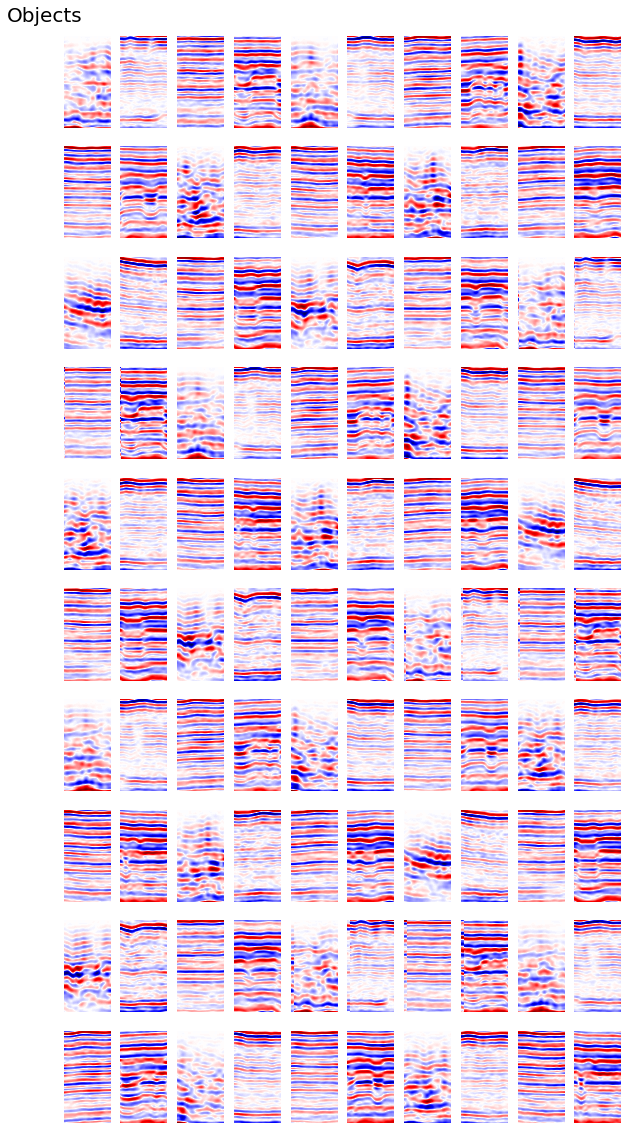

In [ ]:
visualize_objects(objects[:100])

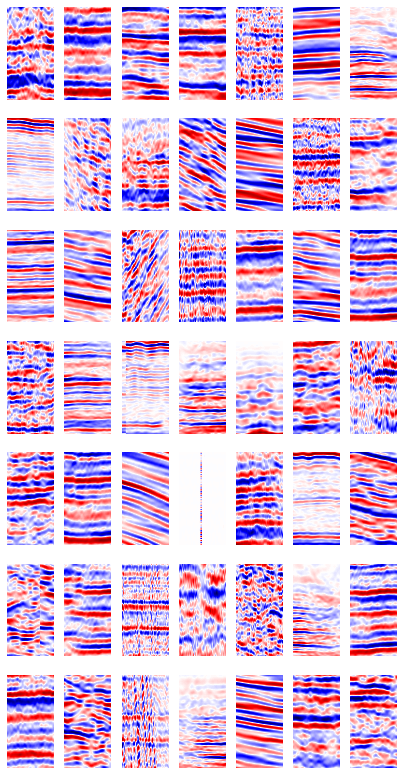

In [ ]:
visualize_objects(objects, random=True)



> 



###**Получение признаковых описаний объектов**

*Можно взять ещё признаки:*
*средние по латерали;*
*сигнальные атрибуты для каждой трассы;*
*выделенные контура для каждого объекта*
*пиксели всего объекта (разреза);*



In [ ]:
def create_features1(var_name, objects, samples_step = 2, draw = False, save = True):
# для каждого объекта сигнальные (усредняем) и CV-атрибуты
# var_name - для сохранения
# из массива объектов получает массив признаков
# samples_step - время одного дискрета в мс
# draw, save - параметры для визуализации результатов вычисления

    def feat_of_one_obj(obj):
    # вычисляет признаки для одного объекта

        names_attrs = np.array(["средняя амплитуда", "среднеквадратичная амплитуда", \
        "частота максимума спектра", "энергия спектра", "ширина спектра", "центральная частота", "доля важной энергии спектра", \
        "временная разреженность", "динамическая выраженность", "индекс полосы пропускания", "доминантная частота", \
        "максимальная длина линий Хафа", "средняя длина линий Хафа", \
        "среднее угла линии Хафа (обратная величина)", "взвешенное среднее угла линии Хафа (обратная величина)", "стандартное отклонение угла линии Хафа (обратная величина)", \
        "максимальная длина контура", "средняя длина контура", "максимальная спрямлённость", "средняя спрямлённость"])

        for_obj_attrs = dict.fromkeys(names_attrs, 0)

        num_of_traces_in_objent = obj.shape[0]
        num_of_samples_in_objent = obj.shape[1]

        # АМПЛИТУДНЫЕ
        for_obj_attrs["средняя амплитуда"] = round(np.abs(obj).sum()/num_of_traces_in_objent/num_of_samples_in_objent, 5)
        for_obj_attrs["среднеквадратичная амплитуда"] = round((obj**2).sum()**(0.5)/num_of_traces_in_objent/num_of_samples_in_objent, 6)

        # СПЕКТРАЛЬНЫЕ
        # преобразование Фурье - линейная операция, поэтому можем взять Фурье от средней трассы
        # (в отличие от АКФ, где надо считать среднее от АКФ каждой трассы)
        m_trace = obj.sum(axis = 0)/num_of_traces_in_objent
        fourier = np.fft.fft(m_trace)
        fourier = fourier[int(fourier.size/2):]
        fourier = fourier[::-1]

        f_discr = 1/(samples_step/1000) # частота дискретизации (не забыли, что samples_step в мс)
        df = f_discr/num_of_samples_in_objent # шаг по частоте (ДПФ: число дискретов образа = числу дискретов прообраза)
        faxis = np.arange(0, int(round(f_discr/2)), df) # f_discr/2 - частота Найквиста
        spectra = 2/(f_discr*num_of_samples_in_objent) * (abs(fourier))**2 # нормируем квадрат амплитудного спектра

        for_obj_attrs["частота максимума спектра"] = round(spectra.argmax() * df, 5)
        for_obj_attrs["энергия спектра"] = np.trapz(spectra[:spectra.size], x=faxis)

        if spectra.max() != 0:
            for_obj_attrs["ширина спектра"] = round(for_obj_attrs["энергия спектра"]/spectra.max(), 5)

        # Здесь считаем центральную частоту по критерию, что энергии от Fmax/2 до неё и от неё до 2*Fmax совпадают
        # или, в нашем случае, отличаются друг от друга не более, чем на 5% полной энергии
        Edelta = for_obj_attrs["энергия спектра"]*0.05

        Fc, Er, El = 0, 0, 0
        # Проходим от Fmax/2 до 2*Fmax, считая обе энергии на каждом шаге и сравнивая их
        for i in range(int(np.argmax(spectra)/2)+1, int(2*np.argmax(spectra))-1):
            Fc = i*df
            try:
                El = np.trapz(spectra[int(np.argmax(spectra)/2):i], x=np.arange(np.argmax(spectra)/2*df, Fc, df))
            except ValueError:
                El = (i - int(np.argmax(spectra)/2))*df*spectra.max()/2
            try:
                Er = np.trapz(spectra[i:int(round(2*np.argmax(spectra)))], x=np.arange(Fc+df/2, 2*np.argmax(spectra)*df, df))
            except ValueError:
                Er = (int(round(2*np.argmax(spectra))) - i)*df*spectra.max()/2
            if abs(Er - El) < Edelta:
                break

        for_obj_attrs["центральная частота"] = round(Fc, 5)
        for_obj_attrs["доля важной энергии спектра"] = round((El + Er)/for_obj_attrs["энергия спектра"], 5)

        for_obj_attrs["энергия спектра"] =round(for_obj_attrs["энергия спектра"], 5) # в двух местах до этого используется: нет смысла округлять там

        # КОРРЕЛЯЦИОННЫЕ
        acfField = np.array([])
        for trace in obj:
            temp = np.correlate(trace, trace, mode='full')
            temp = temp[int(temp.size/2):]
            acfField = np.append(acfField, temp)
        acfField = np.reshape(acfField, (num_of_traces_in_objent, num_of_samples_in_objent))

        acf_params = np.array([])
        for acf_of_trace in acfField:
            acf_max = acf_of_trace.max()
            # нахождение индексов массива, после которых значение массива меняет знак
            acf_zeros = np.diff(np.sign(acf_of_trace))
            try:
                maxtomin_index = np.where(acf_zeros == -2)[0][0]
                mintomax_index = np.where(acf_zeros == 2)[0][0]
                acf_fmin = acf_of_trace[0 : mintomax_index + 1].min()
                ind_fmin = acf_of_trace[0 : mintomax_index + 1].argmin()
                x_fall1 = maxtomin_index
                y_fall1 = acf_of_trace[x_fall1]
                x_fall2 = maxtomin_index + 1
                
                #результат очень сильно зависит от способа интерполяции, поэтому вообще не будем интерполировать
                ind_fzero = x_fall2
                acf_params = np.append(acf_params, np.array([acf_max, -acf_fmin, ind_fmin, ind_fzero,2-ind_fmin/ind_fzero,1-(-acf_fmin)/acf_max,((2-ind_fmin/ind_fzero)**2+(1-(-acf_fmin)/acf_max)**2)**0.5,1/(4*ind_fzero*samples_step/1000)]))
            except IndexError:
                acf_params = np.append(acf_params, np.array([0,0,0,0,  -1,-1,-1,-1]))

        acf_params = np.reshape(acf_params, (num_of_traces_in_objent, 8))

        acf_params_mean = acf_params.sum(axis = 0)/num_of_traces_in_objent

        for_obj_attrs["временная разреженность"] = round(acf_params_mean[4], 5)
        for_obj_attrs["динамическая выраженность"] = round(acf_params_mean[5], 5)
        for_obj_attrs["индекс полосы пропускания"] = round(acf_params_mean[6], 5)
        for_obj_attrs["доминантная частота"] = round(acf_params_mean[7], 5)

        # ЗРЕНИЕ МАШИНЫ
        # делаем изображение серым (отображаем значения амплитуд в интервал 0-255, приводим полученный массив к типу byte)
        ampField_T = obj.T
        im = (np.flip(ampField_T, axis=0) - ampField_T.min())/(ampField_T.max() - ampField_T.min())*255
        im = 255 - im
        im = im.astype(np.uint8)
        im = np.flip(im)

        # чуть-чуть заблюриваем картинку (чтобы убрать шум)
        blur = cv2.GaussianBlur(im, (3,3), 0)

        # применяем пороговый фильтр
        # (алгоритм Отсу вычисляет оптимальное значение порога по точке, равноудалённой от двух пиков гистограммы,
        # соответствующих чёрному и белому цветам)
        ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # делаем скелетизацию, т.е. истончение белых участков изображения до линий толщиной в 1 пиксель
        thresh2 = thresh.copy()
        size = np.size(thresh2)
        skel = np.zeros(thresh.shape, np.uint8)
        element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

        done = False
        while (not done):
            eroded = cv2.erode(thresh2, element)
            temp = cv2.dilate(eroded, element)
            temp = cv2.subtract(thresh2, temp)
            skel = cv2.bitwise_or(skel, temp)
            thresh2 = eroded.copy()
            zeros = size - cv2.countNonZero(thresh2)
            if zeros == size:
                done = True

        # делаем преобразование Хафа (его оптимизированную версию Probabilistic Hough Transform), которое на выходе даёт нам все найденные прямолинейные отрезки
        # skel - подаваемое изображение
        # lines - туда запишутся тета и ро каждой задетектированной линии (пишет координаты начала и конца каждой линии)
        # 2ой аргумент - разрешение по ро в пикселях
        # 3ий - разрешение по тета в радианах
        # 4ый - порог детектирования (сколько пересечений синусоид достаточно для признания линии; количество точек в линии, чтобы та задетектировалась)
        # 5ый - минимальное количество точек, способных сформировать линию (только для HoughLinesP)
        # 6ой - максимальное расстояние между двумя точками, чтобы считать, что эти точки лежат на одной линии (только для HoughLinesP)
        linesP = cv2.HoughLinesP(skel, 30, 0.3*np.pi/180, 200, None, 2, 2)
        
        #if linesP is None:
        #    print("linesP is None")
        #else:
        #    print("!!!!!!!!!!!!")
        #plt_Hl = np.zeros(shape=[im.shape[0], im.shape[1], 3], dtype=np.uint8)

        if draw == True:
          plt_Hl = np.zeros(shape=[im.shape[0], im.shape[1], 3], dtype=np.uint8) # picture for Hough lines

        houghLenghts = []
        houghAngles = []
        # для каждого отрезка находим длину и угол и сразу рисуем их на выделенном для них фоне, цветом обозначаем угол
        # затем вычисляем среднюю и максимальную длину, а также разброс по углам
        if linesP is not None:
            for i in range(len(linesP)):

                l = linesP[i][0] # координаты начала и конца очередной линии
                length = ((l[2]-l[0])**2 + (l[3]-l[1])**2)**0.5 # длина очередной линии
                houghLenghts.append(length)

                angle = np.arctan((l[3]-l[1])/(l[2]-l[0]+0.0001)) # угол наклона очередной линии
                houghAngles.append(angle*180/math.pi) # в градусах

                if draw == True:
                  #hsv_to_rgb переводит из HSV (координаты: цветовой тон от 0 до 360 градусов (поэтому и делим на math.pi), насыщенность и яркость) в RGB (красный, зеленый, синий)
                  #задаём цвет в HSV, потому что сам по себе цвет задаётся только первой координатой
                  color = colorsys.hsv_to_rgb((angle+math.pi/2)/math.pi, 1, 1)
                  color = tuple([255*x for x in color])

                  #изображение, координаты отрезка, цвет, толщина, cv2.LINE_AA - чтобы отрезок был сглажен
                  cv2.line(plt_Hl, (l[0], l[1]), (l[2], l[3]), color, 1, cv2.LINE_AA) # система RGB (для matplotlib)

            maxHLen = max(houghLenghts)
            avgHLen = np.average(houghLenghts)
            avgHAng = np.average(houghAngles)
            avgHAngW = np.average(houghAngles, weights=np.array(houghLenghts)/max(houghLenghts))
            stdHAng = np.std(houghAngles)
            if avgHAng != 0:
                avgHAng = 1 / avgHAng
            if avgHAngW != 0:
                avgHAngW = 1 / avgHAngW
            if stdHAng != 0:
                stdHAng = 1 / stdHAng
        else:
            maxHLen = 0
            avgHLen = 0
            avgHAng = 0
            avgHAngW = 0
            stdHAng = 0

        for_obj_attrs["максимальная длина линий Хафа"] = round(maxHLen, 5)
        for_obj_attrs["средняя длина линий Хафа"] = round(avgHLen, 5)
        for_obj_attrs["среднее угла линии Хафа (обратная величина)"] = round(avgHAng, 5)
        for_obj_attrs["взвешенное среднее угла линии Хафа (обратная величина)"] = round(avgHAngW, 5)
        for_obj_attrs["стандартное отклонение угла линии Хафа (обратная величина)"] = round(stdHAng, 5)

        # ищем контуры
        contours, hierarchy = cv2.findContours(skel, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        if draw == True:
          # создаются чёрные фоновые изображения, на которых будем рисовать контуры и линии
          plt_Tr = np.zeros(shape=[im.shape[0], im.shape[1], 3], dtype=np.uint8) # for Traceability
          plt_Str = plt_Tr.copy() # for Straightness

        lengths = []            # Длины по всем контурам
        straightnesses = []     # Спрямлённости
        if contours is not None:
            for cnt in contours:
                # cv2.arcLength - длина подаваемой кривой, False - говорим, что наша кривая незамкнутая
                lengths.append(cv2.arcLength(cnt, False))

                # cv2.boundingRect - the function calculates and returns the minimal up-right bounding rectangle for the specified point set
                cntRect = cv2.boundingRect(cnt)
                # спрямлённость: cntRect[3] - высота прямоугольника, описывающего контур, cntRect[2] - его ширина
                straightnesses.append(1 - cntRect[3]/cntRect[2])

                if draw == True:
                  color1 = colorsys.hsv_to_rgb(0.75 - cntRect[3]/cntRect[2], 1, 1)
                  color = colorsys.hsv_to_rgb(cv2.arcLength(cnt, False)/num_of_traces_in_objent*2, 1, 1 - cntRect[3]/cntRect[2])

                  color = tuple([255*x for x in color])
                  color1 = tuple([255*x for x in color1])
                  
                  cv2.drawContours(plt_Tr, [cnt], -1, color, 1) # система RGB (для matplotlib)
                  cv2.drawContours(plt_Str, [cnt], -1, color1, 1) # система RGB (для matplotlib)

            maxCLen = max(lengths)
            avgCLen = np.average(lengths)
            maxStraightness = max(straightnesses)
            avgStraightness = np.average(straightnesses)

        else:
            maxCLen = 0
            avgCLen = 0
            maxStraightness = 0
            avgStraightness = 0

        for_obj_attrs["максимальная длина контура"] = round(maxCLen, 5)
        for_obj_attrs["средняя длина контура"] = round(avgCLen, 5)
        for_obj_attrs["максимальная спрямлённость"] = round(maxStraightness, 5)
        for_obj_attrs["средняя спрямлённость"] = round(avgStraightness, 5)

        if draw == True:
          visualize_objects(obj)
          plt.show()

          fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(6, 18))
          
          a1 = ax1.imshow(plt_Hl, cmap="seismic") # цветом выделяется угол наклона
          ax1.set_title("Hough")
          #fig.colorbar(a1, ax=ax1)
          a2 = ax2.imshow(plt_Tr, cmap="seismic") # цветом выделяется длина контура
          ax2.set_title("Trans")
          #fig.colorbar(fig, ax=ax2)
          a3 = ax3.imshow(plt_Str, cmap="seismic") # цветом выделяется спрямленность контура
          ax3.set_title("Straight")
          #fig.colorbar(fig, ax=ax3)

          #norm1 = colors.Normalize(vmin=0, vmax=2000)
          #norm2 = colors.Normalize(vmin=0, vmax=180)
          #cmap2 = colors.LinearSegmentedColormap.from_list('mycmap', ['Cyan','Lime','Yellow','Red','Magenta','Blue'])
          #norm3 = colors.Normalize(vmin=0, vmax=1)

          #Cb1 = colorbar.ColorbarBase(ax1, norm=norm1)
          #Cb2 = colorbar.ColorbarBase(ax2, cmap=cmap2, norm=norm2)
          #Cb3 = colorbar.ColorbarBase(ax3, norm=norm3)

          plt.show()

          print()
          for keys, values in for_obj_attrs.items():
            print(keys, ' = ', values)
          print()

        return for_obj_attrs
    
    if len(objects.shape) == 2: # если подали только один объект
      attrs = np.array(list(feat_of_one_obj(objects).values()))
      attrs = attrs[np.newaxis, :]
      return attrs

    attrs = np.array(list(feat_of_one_obj(objects[0]).values()))
    attrs = attrs[np.newaxis, :]

    for elem in tqdm(objects[1:]):     
        attrs_for_iteration = np.array(list(feat_of_one_obj(elem).values()))
        attrs_for_iteration = attrs_for_iteration[np.newaxis, :]
        attrs = np.concatenate(( attrs, attrs_for_iteration ), axis = 0)
    
    if save == True:
      name_file = "{0}__tr={1}_smpl={2}.npy".format(var_name, objects[0].shape[0], objects[0].shape[1])
      np.save(way + name_file, attrs)

    return attrs

In [ ]:
def create_features2(var_name, objects, samples_step = 2, draw = False, save = True):
# для каждого объекта получает усреднённые сигнальные и CV-атрибуты, сигнальные для каждой трассы, сохраняет картины контуров (черно-белую и со спрямлённостью)
# var_name - для сохранения
# из массива объектов получает массив признаков
# samples_step - время одного дискрета в мс
# draw, save - параметры для визуализации результатов вычисления
# если надо подать один объект (например, второй по индексу), подавать в формате create_features2('your var_name', objects[2:3])

  def feat_of_one_obj(obj):
  # вычисляет признаки для одного объекта

          traces_in_object = obj.shape[0]
          samples_in_object = obj.shape[1]

          stand_attrs = [] # ПРИЗНАКИ

          # АМПЛИТУДНЫЕ

          # все средние по трассам (obj размером 50x100)
          all_means = np.mean( np.abs(obj), axis=1 ) # ПРИЗНАКИ
          all_stds = np.std( obj, axis=1 ) # ПРИЗНАКИ
          mean = np.mean(all_means) # ПРИЗНАКИ
          stand_attrs.append(mean)
          std = np.std(np.std(obj, axis=1)) # ПРИЗНАКИ
          stand_attrs.append(std)

          # СПЕКТРАЛЬНЫЕ
          samples_step = 2
          spectr_attrs = [] # ПРИЗНАКИ

          meanTrace = np.mean(obj, axis=0)
          obj_withMeanTrace = np.vstack((meanTrace, obj)) # первая трасса - средняя (она даёт обычные спектральные атрибуты)
          for l, trace in zip(range(obj_withMeanTrace.shape[0]), obj_withMeanTrace):

            fourier = np.fft.fft(trace)
            fourier = fourier[int(fourier.size/2):]
            fourier = fourier[::-1]

            f_discr = 1/(samples_step/1000) # частота дискретизации (не забыли, что samples_step в мс)
            df = f_discr/samples_in_object # шаг по частоте (ДПФ: число дискретов образа = числу дискретов прообраза)
            faxis = np.arange(0, int(round(f_discr/2)), df) # f_discr/2 - частота Найквиста
            spectra = 2/(f_discr*samples_in_object) * (abs(fourier))**2 # нормируем квадрат амплитудного спектра

            freq_of_max = spectra.argmax() * df
            if l == 0:
              stand_attrs.append(freq_of_max)
            else:
              spectr_attrs.append(freq_of_max) # частота максимума спектра # ПРИЗНАКИ
            
            energSpec = np.trapz(spectra[:spectra.size], x=faxis) # энергия спектра # ПРИЗНАКИ
            if l == 0:
              stand_attrs.append(energSpec) # энергия спектра
            else:
              spectr_attrs.append(energSpec)

            spW = 0
            if spectra.max() != 0:
              spW = energSpec / spectra.max() # ширина спектра # ПРИЗНАКИ

            if l == 0:
              stand_attrs.append(spW) 
            else:
              spectr_attrs.append(spW)

            # Здесь считаем центральную частоту по критерию, что энергии от Fmax/2 до неё и от неё до 2*Fmax совпадают
            # или, в нашем случае, отличаются друг от друга не более, чем на 5% полной энергии
            Edelta = energSpec*0.05

            Fc, Er, El = 0, 0, 0
            # Проходим от Fmax/2 до 2*Fmax, считая обе энергии на каждом шаге и сравнивая их
            for i in range(int(np.argmax(spectra)/2)+1, int(2*np.argmax(spectra))-1):
              Fc = i*df
              try:
                  El = np.trapz(spectra[int(np.argmax(spectra)/2):i], x=np.arange(np.argmax(spectra)/2*df, Fc, df))
              except ValueError:
                  El = (i - int(np.argmax(spectra)/2))*df*spectra.max()/2
              try:
                  Er = np.trapz(spectra[i:int(round(2*np.argmax(spectra)))], x=np.arange(Fc+df/2, 2*np.argmax(spectra)*df, df))
              except ValueError:
                  Er = (int(round(2*np.argmax(spectra))) - i)*df*spectra.max()/2
              if abs(Er - El) < Edelta:
                  break
            
            if l == 0:
              stand_attrs.append(Fc) # центральная частота # ПРИЗНАКИ
            else:
              spectr_attrs.append(Fc)
            
            if energSpec != 0:
              K = (El + Er) / energSpec
              
            if l == 0:
              stand_attrs.append(K) # доля важной энергии спектра # ПРИЗНАКИ
            else:
              spectr_attrs.append(K)
          
          # КОРРЕЛЯЦИОННЫЕ
          acfField = np.array([]) # АКФ для всех трасс
          for trace in obj:
              temp = np.correlate(trace, trace, mode='full')
              temp = temp[int(temp.size/2):]
              acfField = np.append(acfField, temp)
          acfField = np.reshape(acfField, (traces_in_object, samples_in_object))

          acf_params = np.array([]) # ПРИЗНАКИ
          for acf_of_trace in acfField:
              acf_max = acf_of_trace.max()
              # нахождение индексов массива, после которых значение массива меняет знак
              acf_zeros = np.diff(np.sign(acf_of_trace))
              try:
                  maxtomin_index = np.where(acf_zeros == -2)[0][0]
                  mintomax_index = np.where(acf_zeros == 2)[0][0]
                  acf_fmin = acf_of_trace[0 : mintomax_index + 1].min()
                  ind_fmin = acf_of_trace[0 : mintomax_index + 1].argmin()
                  x_fall1 = maxtomin_index
                  y_fall1 = acf_of_trace[x_fall1]
                  x_fall2 = maxtomin_index + 1
                  
                  #результат очень сильно зависит от способа интерполяции, поэтому вообще не будем интерполировать
                  ind_fzero = x_fall2
                  acf_params = np.append(acf_params, np.array([2-ind_fmin/ind_fzero,1-(-acf_fmin)/acf_max,((2-ind_fmin/ind_fzero)**2+(1-(-acf_fmin)/acf_max)**2)**0.5,1/(4*ind_fzero*samples_step/1000)]))
              except IndexError:
                  acf_params = np.append(acf_params, np.array([-1,-1,-1,-1]))

          acf_params_reshape = np.reshape(acf_params, (traces_in_object, 4))

          acf_params_mean = acf_params_reshape.sum(axis = 0)/traces_in_object

          # в конце добавим обычный усреднённый варинат
          stand_attrs.append(acf_params_mean[0]) # временная разреженность # ПРИЗНАКИ
          stand_attrs.append(acf_params_mean[1]) # динамическая выраженность # ПРИЗНАКИ
          stand_attrs.append(acf_params_mean[2]) # индекс полосы пропускания # ПРИЗНАКИ
          stand_attrs.append(acf_params_mean[3]) # доминантная частота # ПРИЗНАКИ

          # ЗРЕНИЕ МАШИНЫ
          # делаем изображение серым (отображаем значения амплитуд в интервал 0-255, приводим полученный массив к типу byte)
          ampField_T = obj.T
          im = (np.flip(ampField_T, axis=0) - ampField_T.min())/(ampField_T.max() - ampField_T.min())*255
          im = 255 - im
          im = im.astype(np.uint8)
          im = np.flip(im)

          # чуть-чуть заблюриваем картинку (чтобы убрать шум)
          blur = cv2.GaussianBlur(im, (3,3), 0)

          # применяем пороговый фильтр
          # (алгоритм Отсу вычисляет оптимальное значение порога по точке, равноудалённой от двух пиков гистограммы,
          # соответствующих чёрному и белому цветам)
          ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

          # делаем скелетизацию, т.е. истончение белых участков изображения до линий толщиной в 1 пиксель
          thresh2 = thresh.copy()
          size = np.size(thresh2)
          skel = np.zeros(thresh.shape, np.uint8)
          element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

          done = False
          while (not done):
              eroded = cv2.erode(thresh2, element)
              temp = cv2.dilate(eroded, element)
              temp = cv2.subtract(thresh2, temp)
              skel = cv2.bitwise_or(skel, temp)
              thresh2 = eroded.copy()
              zeros = size - cv2.countNonZero(thresh2)
              if zeros == size:
                  done = True

          # делаем преобразование Хафа (его оптимизированную версию Probabilistic Hough Transform), которое на выходе даёт нам все найденные прямолинейные отрезки
          # skel - подаваемое изображение
          # lines - туда запишутся тета и ро каждой задетектированной линии (пишет координаты начала и конца каждой линии)
          # 2ой аргумент - разрешение по ро в пикселях
          # 3ий - разрешение по тета в радианах
          # 4ый - порог детектирования (сколько пересечений синусоид достаточно для признания линии; количество точек в линии, чтобы та задетектировалась)
          # 5ый - минимальное количество точек, способных сформировать линию (только для HoughLinesP)
          # 6ой - максимальное расстояние между двумя точками, чтобы считать, что эти точки лежат на одной линии (только для HoughLinesP)
          linesP = cv2.HoughLinesP(skel, 30, 0.3*np.pi/180, 200, None, 2, 2)

          if draw == True:
            plt_Hl = np.zeros(shape=[im.shape[0], im.shape[1], 3], dtype=np.uint8) # picture for Hough lines

          houghLenghts = []
          houghAngles = []
          maxHLen = 0
          avgHLen = 0
          avgHAng = 0
          avgHAngW = 0
          stdHAng = 0
          # для каждого отрезка находим длину и угол и сразу рисуем их на выделенном для них фоне, цветом обозначаем угол
          # затем вычисляем среднюю и максимальную длину, а также разброс по углам
          if linesP is not None:
              for i in range(len(linesP)):

                  l = linesP[i][0] # координаты начала и конца очередной линии
                  length = ((l[2]-l[0])**2 + (l[3]-l[1])**2)**0.5 # длина очередной линии
                  houghLenghts.append(length)

                  angle = np.arctan((l[3]-l[1])/(l[2]-l[0]+0.0001)) # угол наклона очередной линии
                  houghAngles.append(angle*180/math.pi) # в градусах

                  if draw == True:
                    #hsv_to_rgb переводит из HSV (координаты: цветовой тон от 0 до 360 градусов (поэтому и делим на math.pi), насыщенность и яркость) в RGB (красный, зеленый, синий)
                    #задаём цвет в HSV, потому что сам по себе цвет задаётся только первой координатой
                    color = colorsys.hsv_to_rgb((angle+math.pi/2)/math.pi, 1, 1)
                    color = tuple([255*x for x in color])

                    #изображение, координаты отрезка, цвет, толщина, cv2.LINE_AA - чтобы отрезок был сглажен
                    cv2.line(plt_Hl, (l[0], l[1]), (l[2], l[3]), color, 1, cv2.LINE_AA) # система RGB (для matplotlib)

              maxHLen = max(houghLenghts)
              avgHLen = np.average(houghLenghts)
              avgHAng = np.average(houghAngles)
              avgHAngW = np.average(houghAngles, weights=np.array(houghLenghts)/max(houghLenghts))
              stdHAng = np.std(houghAngles)
              if avgHAng != 0:
                  avgHAng = 1 / avgHAng
              if avgHAngW != 0:
                  avgHAngW = 1 / avgHAngW
              if stdHAng != 0:
                  stdHAng = 1 / stdHAng

          stand_attrs.append(maxHLen) # максимальная длина линий Хафа # ПРИЗНАКИ
          stand_attrs.append(avgHLen) # средняя длина линий Хафа # ПРИЗНАКИ
          stand_attrs.append(avgHAng) # среднее угла линии Хафа (обратная величина) # ПРИЗНАКИ
          stand_attrs.append(avgHAngW) # взвешенное среднее угла линии Хафа (обратная величина) # ПРИЗНАКИ
          stand_attrs.append(stdHAng) # стандартное отклонение угла линии Хафа (обратная величина) # ПРИЗНАКИ

          # ищем контуры
          contours, hierarchy = cv2.findContours(skel, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

          # создаются чёрные фоновые изображения, на которых будем рисовать контуры
          plt_Feat = np.zeros(shape=[im.shape[0], im.shape[1]], dtype=np.uint8) # ПРИЗНАКИ
          plt_Str = np.zeros(shape=[im.shape[0], im.shape[1], 3], dtype=np.uint8) # for Straightness # ПРИЗНАКИ
          if draw == True:
            plt_Tr = plt_Str.copy() # for Traceability

          lengths = []            # Длины по всем контурам # ПРИЗНАКИ
          straightnesses = []     # Спрямлённости # ПРИЗНАКИ
          maxCLen = 0
          avgCLen = 0
          maxStraightness = 0
          avgStraightness = 0
          if contours is not None:
              for cnt in contours:
                  # cv2.arcLength - длина подаваемой кривой, False - говорим, что наша кривая незамкнутая
                  lengths.append(cv2.arcLength(cnt, False))

                  # cv2.boundingRect - the function calculates and returns the minimal up-right bounding rectangle for the specified point set
                  cntRect = cv2.boundingRect(cnt)
                  # спрямлённость: cntRect[3] - высота прямоугольника, описывающего контур, cntRect[2] - его ширина
                  straightnesses.append(1 - cntRect[3]/cntRect[2])

                  cv2.drawContours(plt_Feat, [cnt], -1, [255,255,255], 1)

                  color1 = colorsys.hsv_to_rgb(0.75 - cntRect[3]/cntRect[2], 1, 1)
                  color1 = tuple([255*x for x in color1])
                  cv2.drawContours(plt_Str, [cnt], -1, color1, 1) # система RGB (для matplotlib)

                  if draw == True:
                    color = colorsys.hsv_to_rgb(cv2.arcLength(cnt, False)/traces_in_object*2, 1, 1 - cntRect[3]/cntRect[2])
                    color = tuple([255*x for x in color])
                    cv2.drawContours(plt_Tr, [cnt], -1, color, 1) # система RGB (для matplotlib)
                    

              maxCLen = max(lengths) # ПРИЗНАКИ
              avgCLen = np.average(lengths) # ПРИЗНАКИ
              maxStraightness = max(straightnesses) # ПРИЗНАКИ
              avgStraightness = np.average(straightnesses) # ПРИЗНАКИ

          stand_attrs.append(maxCLen) # максимальная длина контура # ПРИЗНАКИ
          stand_attrs.append(avgCLen) # средняя длина контура # ПРИЗНАКИ
          stand_attrs.append(maxStraightness) # максимальная спрямлённость # ПРИЗНАКИ
          stand_attrs.append(avgStraightness) # средняя спрямлённость # ПРИЗНАКИ
          stand_attrs.append(len(lengths)) # число найденных контуров # ПРИЗНАКИ

          if draw == True:
            visualize_objects(obj)
            plt.show()

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(6, 24))
            
            a1 = ax1.imshow(plt_Hl, cmap="seismic") # цветом выделяется угол наклона
            ax1.set_title("Hough")

            a2 = ax2.imshow(plt_Tr, cmap="seismic") # цветом выделяется длина контура
            ax2.set_title("Trans")

            a3 = ax3.imshow(plt_Str, cmap="seismic") # цветом выделяется спрямленность контура
            ax3.set_title("Straight")

            a4 = ax4.imshow(plt_Feat)
            ax4.set_title("Feat")

            plt.show()

            names_attrs = np.array(["средняя амплитуда", "среднеквадратичная амплитуда", \
            "частота максимума спектра", "энергия спектра", "ширина спектра", "центральная частота", "доля важной энергии спектра", \
            "временная разреженность", "динамическая выраженность", "индекс полосы пропускания", "доминантная частота", \
            "максимальная длина линий Хафа", "средняя длина линий Хафа", \
            "среднее угла линии Хафа (обратная величина)", "взвешенное среднее угла линии Хафа (обратная величина)", "стандартное отклонение угла линии Хафа (обратная величина)", \
            "максимальная длина контура", "средняя длина контура", "максимальная спрямлённость", "средняя спрямлённость", "число контуров"])

            for_obj_attrs = dict(zip(names_attrs, stand_attrs))

            print()
            for keys, values in for_obj_attrs.items():
              print(keys, ' = ', values)
            print()
          
          sign_feat = []
          sign_feat.extend(all_means)
          sign_feat.extend(all_stds)
          sign_feat.extend(spectr_attrs)
          sign_feat.extend(acf_params)

          cv_feat = plt_Feat.flatten()
          #cv_feat_forConv = plt_Feat # потом можно получить через reshape
          
          all_feat = []
          all_feat.extend(stand_attrs)
          all_feat.extend(sign_feat)
          all_feat.extend(cv_feat)
          
          return np.array(all_feat), np.array(plt_Feat)[np.newaxis, :], np.array(plt_Str)[np.newaxis, :]

  features2 = np.zeros(5571)
  pict_bw = np.zeros((1, 100, 50))
  pict_str = np.zeros((1, 100, 50, 3))
  for elem in tqdm(objects):
    f = feat_of_one_obj(elem)
    
    features2 = np.vstack((features2, f[0]))
    pict_bw = np.vstack((pict_bw, f[1]))
    pict_str = np.vstack((pict_str, f[2]))
    
  if save == True:
    name_file = "{0}.npy".format(var_name)
    np.save(way + name_file, features2[1:])
    
    name_file = "{0}_bw.npy".format(var_name)
    np.save(way + name_file, pict_bw[1:])

    name_file = "{0}_str.npy".format(var_name)
    np.save(way + name_file, pict_str[1:])

  return features2[1:], pict_bw[1:], pict_str[1:]



> 



#####Создание матрицы  features1 признаковых описаний

In [ ]:
way = '/content/drive/My Drive/Colab Notebooks/First_features/'

In [ ]:
features1 = create_features1('features1', objects)

100%|██████████| 17079/17079 [01:49<00:00, 155.39it/s]


In [ ]:
features1

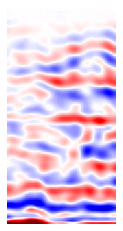

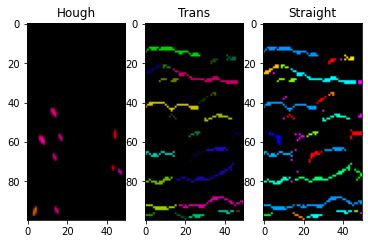

  0%|          | 0/1 [00:00<?, ?it/s]


средняя амплитуда  =  0.36284
среднеквадратичная амплитуда  =  0.007563
частота максимума спектра  =  25.0
энергия спектра  =  0.13478
ширина спектра  =  19.37925
центральная частота  =  40.0
доля важной энергии спектра  =  0.57818
временная разреженность  =  0.091
динамическая выраженность  =  0.5188
индекс полосы пропускания  =  0.60426
доминантная частота  =  32.125
максимальная длина линий Хафа  =  4.47214
средняя длина линий Хафа  =  3.31464
среднее угла линии Хафа (обратная величина)  =  0.02071
взвешенное среднее угла линии Хафа (обратная величина)  =  0.02355
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01774
максимальная длина контура  =  72.87006
средняя длина контура  =  15.66403
максимальная спрямлённость  =  0.82143
средняя спрямлённость  =  0.32816



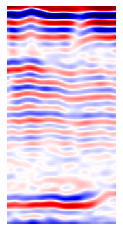

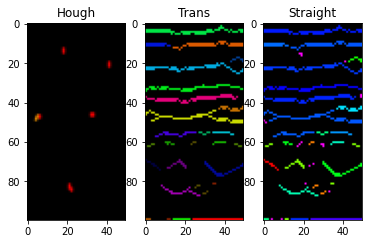

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


средняя амплитуда  =  0.53662
среднеквадратичная амплитуда  =  0.012038
частота максимума спектра  =  85.0
энергия спектра  =  0.53221
ширина спектра  =  25.69983
центральная частота  =  160.0
доля важной энергии спектра  =  0.92652
временная разреженность  =  0.48667
динамическая выраженность  =  0.32654
индекс полосы пропускания  =  0.59649
доминантная частота  =  61.66667
максимальная длина линий Хафа  =  4.0
средняя длина линий Хафа  =  2.6847
среднее угла линии Хафа (обратная величина)  =  -0.01472
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.0173
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01781
максимальная длина контура  =  129.49747
средняя длина контура  =  24.24698
максимальная спрямлённость  =  0.96154
средняя спрямлённость  =  0.44312



array([[ 3.6284000e-01,  7.5630000e-03,  2.5000000e+01,  1.3478000e-01,
         1.9379250e+01,  4.0000000e+01,  5.7818000e-01,  9.1000000e-02,
         5.1880000e-01,  6.0426000e-01,  3.2125000e+01,  4.4721400e+00,
         3.3146400e+00,  2.0710000e-02,  2.3550000e-02,  1.7740000e-02,
         7.2870060e+01,  1.5664030e+01,  8.2143000e-01,  3.2816000e-01],
       [ 5.3662000e-01,  1.2038000e-02,  8.5000000e+01,  5.3221000e-01,
         2.5699830e+01,  1.6000000e+02,  9.2652000e-01,  4.8667000e-01,
         3.2654000e-01,  5.9649000e-01,  6.1666670e+01,  4.0000000e+00,
         2.6847000e+00, -1.4720000e-02, -1.7300000e-02,  1.7810000e-02,
         1.2949747e+02,  2.4246980e+01,  9.6154000e-01,  4.4312000e-01]])

In [ ]:
create_features1('', objects[0:2], draw=True, save=False)

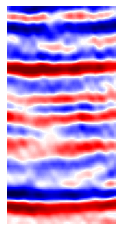

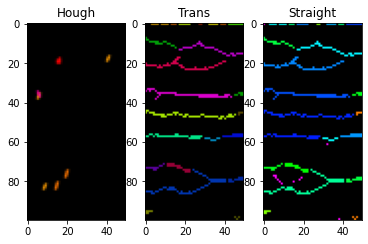

  0%|          | 0/19 [00:00<?, ?it/s]


средняя амплитуда  =  421.89872
среднеквадратичная амплитуда  =  7.708763
частота максимума спектра  =  35.0
энергия спектра  =  249868.18472
ширина спектра  =  15.15785
центральная частота  =  60.0
доля важной энергии спектра  =  0.66994
временная разреженность  =  0.56
динамическая выраженность  =  0.65725
индекс полосы пропускания  =  0.86548
доминантная частота  =  29.625
максимальная длина линий Хафа  =  4.12311
средняя длина линий Хафа  =  3.23692
среднее угла линии Хафа (обратная величина)  =  -0.01684
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.01694
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01999
максимальная длина контура  =  115.39697
средняя длина контура  =  24.2709
максимальная спрямлённость  =  0.89655
средняя спрямлённость  =  0.55104



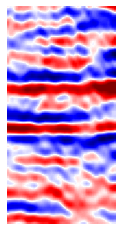

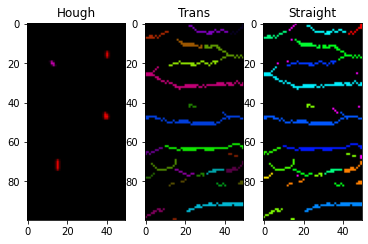

  5%|▌         | 1/19 [00:00<00:07,  2.45it/s]


средняя амплитуда  =  150.88868
среднеквадратичная амплитуда  =  2.717774
частота максимума спектра  =  30.0
энергия спектра  =  24353.13247
ширина спектра  =  18.5519
центральная частота  =  50.0
доля важной энергии спектра  =  0.70547
временная разреженность  =  0.46633
динамическая выраженность  =  0.56881
индекс полосы пропускания  =  0.77966
доминантная частота  =  30.83333
максимальная длина линий Хафа  =  5.0
средняя длина линий Хафа  =  3.06745
среднее угла линии Хафа (обратная величина)  =  0.02593
взвешенное среднее угла линии Хафа (обратная величина)  =  0.03408
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01355
максимальная длина контура  =  122.46804
средняя длина контура  =  22.60839
максимальная спрямлённость  =  0.9
средняя спрямлённость  =  0.39133



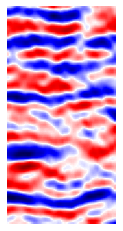

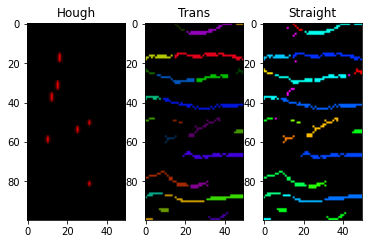

 11%|█         | 2/19 [00:01<00:07,  2.14it/s]


средняя амплитуда  =  112.34711
среднеквадратичная амплитуда  =  1.981664
частота максимума спектра  =  35.0
энергия спектра  =  8532.55401
ширина спектра  =  13.04755
центральная частота  =  60.0
доля важной энергии спектра  =  0.87372
временная разреженность  =  0.526
динамическая выраженность  =  0.57843
индекс полосы пропускания  =  0.82969
доминантная частота  =  30.5
максимальная длина линий Хафа  =  4.0
средняя длина линий Хафа  =  3.14286
среднее угла линии Хафа (обратная величина)  =  0.07778
взвешенное среднее угла линии Хафа (обратная величина)  =  -3839.72436
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01123
максимальная длина контура  =  91.25483
средняя длина контура  =  20.48008
максимальная спрямлённость  =  0.88571
средняя спрямлённость  =  0.51761



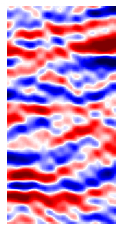

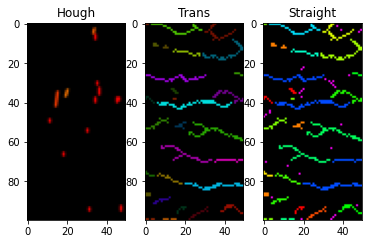

 16%|█▌        | 3/19 [00:01<00:07,  2.23it/s]


средняя амплитуда  =  87.602
среднеквадратичная амплитуда  =  1.586352
частота максимума спектра  =  10.0
энергия спектра  =  4589.20119
ширина спектра  =  16.18821
центральная частота  =  10.0
доля важной энергии спектра  =  0.18649
временная разреженность  =  0.282
динамическая выраженность  =  0.63368
индекс полосы пропускания  =  0.94538
доминантная частота  =  29.66667
максимальная длина линий Хафа  =  8.06226
средняя длина линий Хафа  =  3.2346
среднее угла линии Хафа (обратная величина)  =  -0.02036
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.01839
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01374
максимальная длина контура  =  87.49747
средняя длина контура  =  16.96923
максимальная спрямлённость  =  0.87097
средняя спрямлённость  =  0.30438



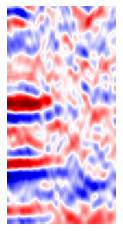

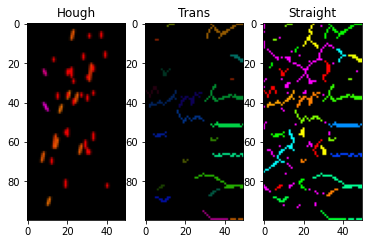

 21%|██        | 4/19 [00:01<00:06,  2.28it/s]


средняя амплитуда  =  385.00069
среднеквадратичная амплитуда  =  7.416279
частота максимума спектра  =  10.0
энергия спектра  =  90550.56029
ширина спектра  =  27.22716
центральная частота  =  10.0
доля важной энергии спектра  =  0.13249
временная разреженность  =  0.04239
динамическая выраженность  =  0.64482
индекс полосы пропускания  =  0.92031
доминантная частота  =  25.90386
максимальная длина линий Хафа  =  9.05539
средняя длина линий Хафа  =  3.50321
среднее угла линии Хафа (обратная величина)  =  0.07527
взвешенное среднее угла линии Хафа (обратная величина)  =  -1.65927
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01174
максимальная длина контура  =  93.05382
средняя длина контура  =  11.85149
максимальная спрямлённость  =  0.875
средняя спрямлённость  =  -0.04455



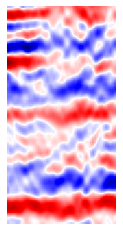

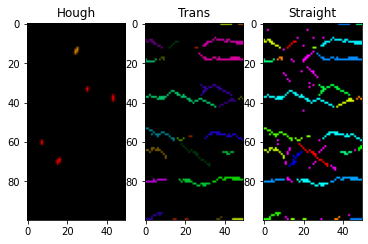

 26%|██▋       | 5/19 [00:02<00:06,  2.31it/s]


средняя амплитуда  =  467.32122
среднеквадратичная амплитуда  =  8.483962
частота максимума спектра  =  20.0
энергия спектра  =  244255.41718
ширина спектра  =  16.55428
центральная частота  =  30.0
доля важной энергии спектра  =  0.52541
временная разреженность  =  -0.04467
динамическая выраженность  =  0.60284
индекс полосы пропускания  =  0.81395
доминантная частота  =  22.2381
максимальная длина линий Хафа  =  3.16228
средняя длина линий Хафа  =  2.36038
среднее угла линии Хафа (обратная величина)  =  -0.01757
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.02094
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01514
максимальная длина контура  =  85.56854
средняя длина контура  =  10.52591
максимальная спрямлённость  =  0.83333
средняя спрямлённость  =  0.22049



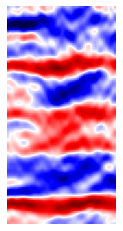

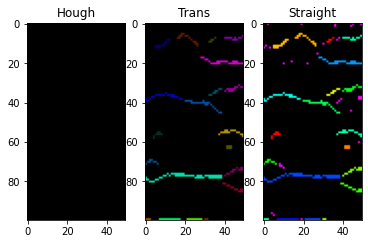

 32%|███▏      | 6/19 [00:02<00:05,  2.34it/s]


средняя амплитуда  =  437.07711
среднеквадратичная амплитуда  =  7.565785
частота максимума спектра  =  10.0
энергия спектра  =  206635.9662
ширина спектра  =  8.33628
центральная частота  =  10.0
доля важной энергии спектра  =  0.32264
временная разреженность  =  0.00529
динамическая выраженность  =  0.62379
индекс полосы пропускания  =  0.84742
доминантная частота  =  19.3631
максимальная длина линий Хафа  =  0
средняя длина линий Хафа  =  0
среднее угла линии Хафа (обратная величина)  =  0
взвешенное среднее угла линии Хафа (обратная величина)  =  0
стандартное отклонение угла линии Хафа (обратная величина)  =  0
максимальная длина контура  =  86.52691
средняя длина контура  =  11.38185
максимальная спрямлённость  =  0.90909
средняя спрямлённость  =  0.26422



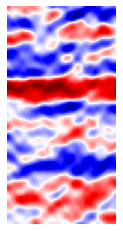

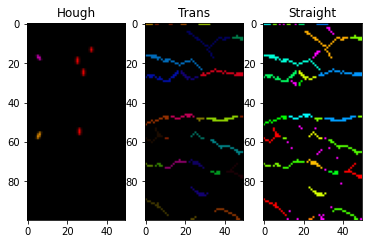

 37%|███▋      | 7/19 [00:03<00:05,  2.38it/s]


средняя амплитуда  =  225.68755
среднеквадратичная амплитуда  =  4.044548
частота максимума спектра  =  15.0
энергия спектра  =  55349.17038
ширина спектра  =  11.23016
центральная частота  =  20.0
доля важной энергии спектра  =  0.42065
временная разреженность  =  0.00648
динамическая выраженность  =  0.66932
индекс полосы пропускания  =  0.85376
доминантная частота  =  20.82143
максимальная длина линий Хафа  =  3.16228
средняя длина линий Хафа  =  2.73306
среднее угла линии Хафа (обратная величина)  =  0.01705
взвешенное среднее угла линии Хафа (обратная величина)  =  0.01811
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01694
максимальная длина контура  =  66.74011
средняя длина контура  =  11.71526
максимальная спрямлённость  =  0.83333
средняя спрямлённость  =  0.28604



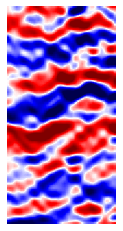

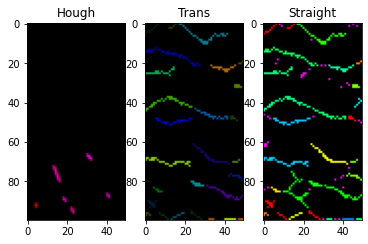

 42%|████▏     | 8/19 [00:03<00:04,  2.37it/s]


средняя амплитуда  =  143.09252
среднеквадратичная амплитуда  =  2.517105
частота максимума спектра  =  15.0
энергия спектра  =  13957.27469
ширина спектра  =  18.22512
центральная частота  =  20.0
доля важной энергии спектра  =  0.46096
временная разреженность  =  0.0899
динамическая выраженность  =  0.61704
индекс полосы пропускания  =  0.7247
доминантная частота  =  25.30357
максимальная длина линий Хафа  =  8.544
средняя длина линий Хафа  =  3.59166
среднее угла линии Хафа (обратная величина)  =  0.03568
взвешенное среднее угла линии Хафа (обратная величина)  =  0.04007
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01526
максимальная длина контура  =  70.3259
средняя длина контура  =  12.15453
максимальная спрямлённость  =  0.83333
средняя спрямлённость  =  0.2186



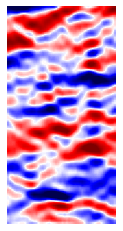

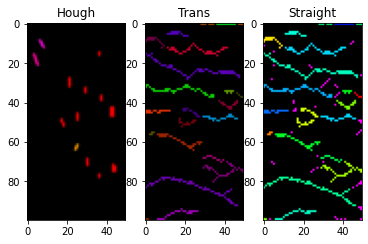

 47%|████▋     | 9/19 [00:03<00:04,  2.42it/s]


средняя амплитуда  =  105.7638
среднеквадратичная амплитуда  =  1.942919
частота максимума спектра  =  5.0
энергия спектра  =  7356.73313
ширина спектра  =  8.96553
центральная частота  =  0
доля важной энергии спектра  =  0.0
временная разреженность  =  -0.11959
динамическая выраженность  =  0.76288
индекс полосы пропускания  =  1.24543
доминантная частота  =  25.43561
максимальная длина линий Хафа  =  6.32456
средняя длина линий Хафа  =  3.62244
среднее угла линии Хафа (обратная величина)  =  -0.01446
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.0168
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01928
максимальная длина контура  =  119.19596
средняя длина контура  =  15.48172
максимальная спрямлённость  =  0.9
средняя спрямлённость  =  0.24759



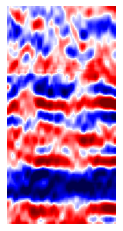

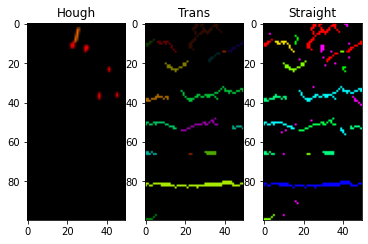

 53%|█████▎    | 10/19 [00:04<00:04,  2.15it/s]


средняя амплитуда  =  373.63894
среднеквадратичная амплитуда  =  6.685683
частота максимума спектра  =  10.0
энергия спектра  =  151479.21769
ширина спектра  =  19.02908
центральная частота  =  10.0
доля важной энергии спектра  =  0.25104
временная разреженность  =  -0.26569
динамическая выраженность  =  0.67586
индекс полосы пропускания  =  1.02779
доминантная частота  =  20.88095
максимальная длина линий Хафа  =  9.21954
средняя длина линий Хафа  =  3.1355
среднее угла линии Хафа (обратная величина)  =  -0.01458
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.01367
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01779
максимальная длина контура  =  105.35534
средняя длина контура  =  13.92011
максимальная спрямлённость  =  0.92
средняя спрямлённость  =  0.14303



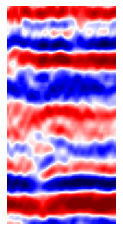

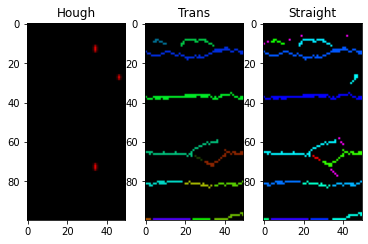

 58%|█████▊    | 11/19 [00:04<00:03,  2.23it/s]


средняя амплитуда  =  588.05575
среднеквадратичная амплитуда  =  10.258719
частота максимума спектра  =  25.0
энергия спектра  =  453791.19264
ширина спектра  =  24.02102
центральная частота  =  40.0
доля важной энергии спектра  =  0.71611
временная разреженность  =  0.30933
динамическая выраженность  =  0.53785
индекс полосы пропускания  =  0.64637
доминантная частота  =  22.75
максимальная длина линий Хафа  =  3.0
средняя длина линий Хафа  =  2.66667
среднее угла линии Хафа (обратная величина)  =  0.01111
взвешенное среднее угла линии Хафа (обратная величина)  =  0.01111
стандартное отклонение угла линии Хафа (обратная величина)  =  2221.44147
максимальная длина контура  =  115.81118
средняя длина контура  =  25.62424
максимальная спрямлённость  =  0.94737
средняя спрямлённость  =  0.43546



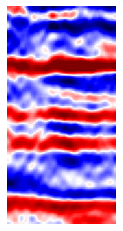

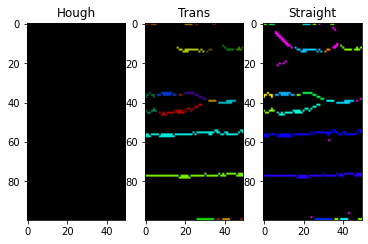

 63%|██████▎   | 12/19 [00:05<00:03,  2.30it/s]


средняя амплитуда  =  389.43011
среднеквадратичная амплитуда  =  6.792686
частота максимума спектра  =  10.0
энергия спектра  =  185534.33828
ширина спектра  =  13.31853
центральная частота  =  10.0
доля важной энергии спектра  =  0.2378
временная разреженность  =  -0.45143
динамическая выраженность  =  0.67636
индекс полосы пропускания  =  1.13394
доминантная частота  =  22.95238
максимальная длина линий Хафа  =  0
средняя длина линий Хафа  =  0
среднее угла линии Хафа (обратная величина)  =  0
взвешенное среднее угла линии Хафа (обратная величина)  =  0
стандартное отклонение угла линии Хафа (обратная величина)  =  0
максимальная длина контура  =  112.25483
средняя длина контура  =  12.71863
максимальная спрямлённость  =  0.94
средняя спрямлённость  =  0.43018



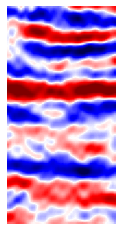

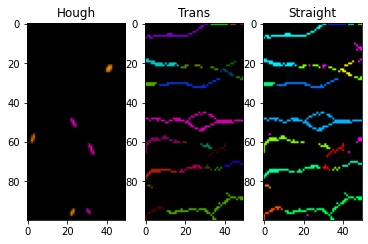

 68%|██████▊   | 13/19 [00:05<00:02,  2.33it/s]


средняя амплитуда  =  243.75297
среднеквадратичная амплитуда  =  4.440519
частота максимума спектра  =  15.0
энергия спектра  =  73088.22514
ширина спектра  =  10.78446
центральная частота  =  20.0
доля важной энергии спектра  =  0.31259
временная разреженность  =  0.407
динамическая выраженность  =  0.55045
индекс полосы пропускания  =  0.69262
доминантная частота  =  24.20833
максимальная длина линий Хафа  =  5.38516
средняя длина линий Хафа  =  3.50384
среднее угла линии Хафа (обратная величина)  =  -0.04979
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.05486
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01442
максимальная длина контура  =  146.61017
средняя длина контура  =  20.57632
максимальная спрямлённость  =  0.88889
средняя спрямлённость  =  0.42662



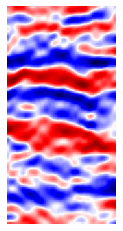

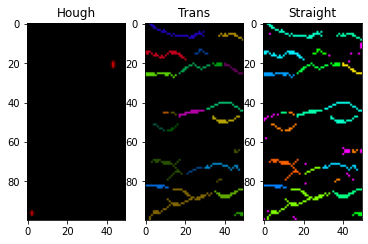

 74%|███████▎  | 14/19 [00:06<00:02,  2.37it/s]


средняя амплитуда  =  149.07046
среднеквадратичная амплитуда  =  2.57609
частота максимума спектра  =  10.0
энергия спектра  =  19941.04647
ширина спектра  =  19.74273
центральная частота  =  10.0
доля важной энергии спектра  =  0.20989
временная разреженность  =  -0.28133
динамическая выраженность  =  0.65577
индекс полосы пропускания  =  0.8899
доминантная частота  =  23.58333
максимальная длина линий Хафа  =  4.0
средняя длина линий Хафа  =  3.07869
среднее угла линии Хафа (обратная величина)  =  -0.02574
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.01892
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01383
максимальная длина контура  =  103.29646
средняя длина контура  =  15.43506
максимальная спрямлённость  =  0.83333
средняя спрямлённость  =  0.2522



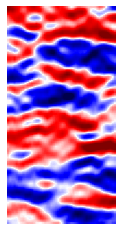

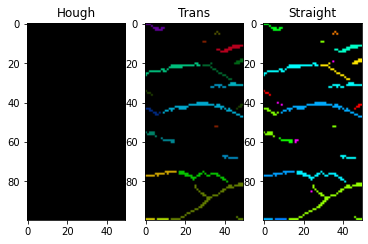

 79%|███████▉  | 15/19 [00:06<00:01,  2.40it/s]


средняя амплитуда  =  130.79998
среднеквадратичная амплитуда  =  2.206745
частота максимума спектра  =  5.0
энергия спектра  =  10532.57085
ширина спектра  =  11.15742
центральная частота  =  0
доля важной энергии спектра  =  0.0
временная разреженность  =  -0.11761
динамическая выраженность  =  0.68929
индекс полосы пропускания  =  0.93644
доминантная частота  =  20.28292
максимальная длина линий Хафа  =  0
средняя длина линий Хафа  =  0
среднее угла линии Хафа (обратная величина)  =  0
взвешенное среднее угла линии Хафа (обратная величина)  =  0
стандартное отклонение угла линии Хафа (обратная величина)  =  0
максимальная длина контура  =  105.05382
средняя длина контура  =  19.45254
максимальная спрямлённость  =  0.83333
средняя спрямлённость  =  0.48272



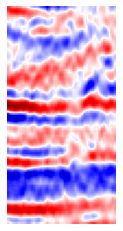

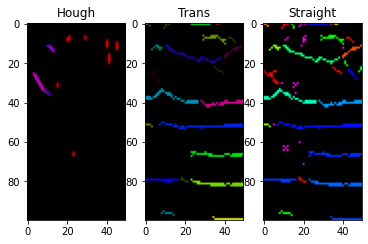

 84%|████████▍ | 16/19 [00:06<00:01,  2.40it/s]


средняя амплитуда  =  363.98081
среднеквадратичная амплитуда  =  6.458639
частота максимума спектра  =  10.0
энергия спектра  =  128520.45398
ширина спектра  =  24.98423
центральная частота  =  10.0
доля важной энергии спектра  =  0.15621
временная разреженность  =  0.16671
динамическая выраженность  =  0.67868
индекс полосы пропускания  =  0.92848
доминантная частота  =  25.00893
максимальная длина линий Хафа  =  10.29563
средняя длина линий Хафа  =  3.5465
среднее угла линии Хафа (обратная величина)  =  0.01606
взвешенное среднее угла линии Хафа (обратная величина)  =  0.01523
стандартное отклонение угла линии Хафа (обратная величина)  =  0.02027
максимальная длина контура  =  91.04163
средняя длина контура  =  15.99339
максимальная спрямлённость  =  0.90698
средняя спрямлённость  =  0.23449



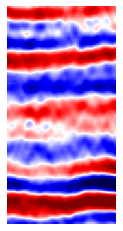

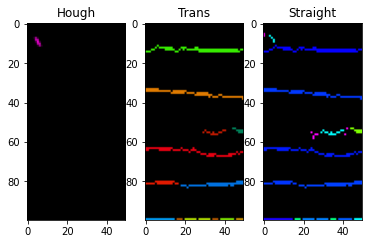

 89%|████████▉ | 17/19 [00:07<00:00,  2.40it/s]


средняя амплитуда  =  620.30814
среднеквадратичная амплитуда  =  10.836523
частота максимума спектра  =  25.0
энергия спектра  =  485778.85245
ширина спектра  =  17.98272
центральная частота  =  25.0
доля важной энергии спектра  =  0.63476
временная разреженность  =  0.284
динамическая выраженность  =  0.45908
индекс полосы пропускания  =  0.55537
доминантная частота  =  23.41667
максимальная длина линий Хафа  =  4.47214
средняя длина линий Хафа  =  4.47214
среднее угла линии Хафа (обратная величина)  =  0.01576
взвешенное среднее угла линии Хафа (обратная величина)  =  0.01576
стандартное отклонение угла линии Хафа (обратная величина)  =  0.0
максимальная длина контура  =  107.35534
средняя длина контура  =  24.24031
максимальная спрямлённость  =  0.93333
средняя спрямлённость  =  0.49572



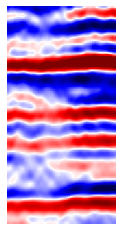

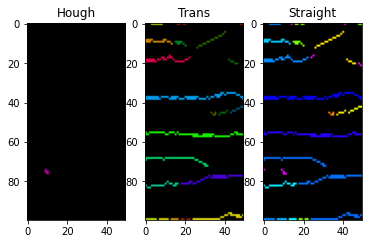

 95%|█████████▍| 18/19 [00:07<00:00,  2.14it/s]


средняя амплитуда  =  490.86473
среднеквадратичная амплитуда  =  9.138271
частота максимума спектра  =  10.0
энергия спектра  =  338488.89477
ширина спектра  =  21.50135
центральная частота  =  10.0
доля важной энергии спектра  =  0.22146
временная разреженность  =  0.109
динамическая выраженность  =  0.62043
индекс полосы пропускания  =  0.98889
доминантная частота  =  25.375
максимальная длина линий Хафа  =  2.23607
средняя длина линий Хафа  =  2.23607
среднее угла линии Хафа (обратная величина)  =  0.01576
взвешенное среднее угла линии Хафа (обратная величина)  =  0.01576
стандартное отклонение угла линии Хафа (обратная величина)  =  0.0
максимальная длина контура  =  113.91169
средняя длина контура  =  21.42468
максимальная спрямлённость  =  0.94
средняя спрямлённость  =  0.51547



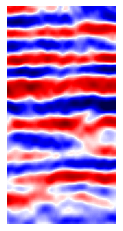

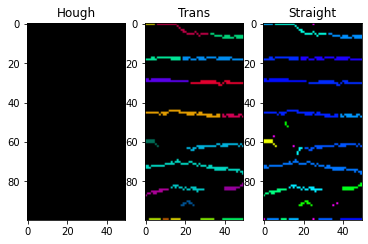

100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


средняя амплитуда  =  246.08125
среднеквадратичная амплитуда  =  4.200384
частота максимума спектра  =  30.0
энергия спектра  =  65661.31174
ширина спектра  =  14.74503
центральная частота  =  50.0
доля важной энергии спектра  =  0.86417
временная разреженность  =  0.285
динамическая выраженность  =  0.39818
индекс полосы пропускания  =  0.4956
доминантная частота  =  31.25
максимальная длина линий Хафа  =  0
средняя длина линий Хафа  =  0
среднее угла линии Хафа (обратная величина)  =  0
взвешенное среднее угла линии Хафа (обратная величина)  =  0
стандартное отклонение угла линии Хафа (обратная величина)  =  0
максимальная длина контура  =  112.08326
средняя длина контура  =  23.3624
максимальная спрямлённость  =  0.93548
средняя спрямлённость  =  0.52186



array([[ 4.21898720e+02,  7.70876300e+00,  3.50000000e+01,
         2.49868185e+05,  1.51578500e+01,  6.00000000e+01,
         6.69940000e-01,  5.60000000e-01,  6.57250000e-01,
         8.65480000e-01,  2.96250000e+01,  4.12311000e+00,
         3.23692000e+00, -1.68400000e-02, -1.69400000e-02,
         1.99900000e-02,  1.15396970e+02,  2.42709000e+01,
         8.96550000e-01,  5.51040000e-01],
       [ 1.50888680e+02,  2.71777400e+00,  3.00000000e+01,
         2.43531325e+04,  1.85519000e+01,  5.00000000e+01,
         7.05470000e-01,  4.66330000e-01,  5.68810000e-01,
         7.79660000e-01,  3.08333300e+01,  5.00000000e+00,
         3.06745000e+00,  2.59300000e-02,  3.40800000e-02,
         1.35500000e-02,  1.22468040e+02,  2.26083900e+01,
         9.00000000e-01,  3.91330000e-01],
       [ 1.12347110e+02,  1.98166400e+00,  3.50000000e+01,
         8.53255401e+03,  1.30475500e+01,  6.00000000e+01,
         8.73720000e-01,  5.26000000e-01,  5.78430000e-01,
         8.29690000e-01,  3.0

In [ ]:
create_features1('', objects[11130:11150], draw=True, save=False)

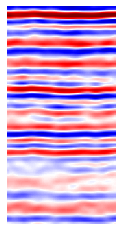

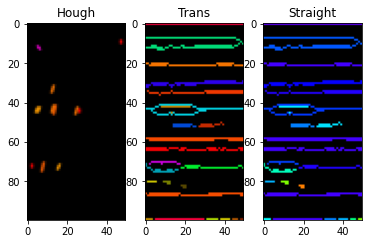


средняя амплитуда  =  0.69332
среднеквадратичная амплитуда  =  0.012685
частота максимума спектра  =  40.0
энергия спектра  =  0.74843
ширина спектра  =  32.94607
центральная частота  =  70.0
доля важной энергии спектра  =  0.51778
временная разреженность  =  0.5
динамическая выраженность  =  0.44681
индекс полосы пропускания  =  0.67085
доминантная частота  =  62.5
максимальная длина линий Хафа  =  5.09902
средняя длина линий Хафа  =  3.39826
среднее угла линии Хафа (обратная величина)  =  -0.02923
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.02478
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01436
максимальная длина контура  =  160.59798
средняя длина контура  =  46.15246
максимальная спрямлённость  =  0.98
средняя спрямлённость  =  0.81013



array([[ 6.9332000e-01,  1.2685000e-02,  4.0000000e+01,  7.4843000e-01,
         3.2946070e+01,  7.0000000e+01,  5.1778000e-01,  5.0000000e-01,
         4.4681000e-01,  6.7085000e-01,  6.2500000e+01,  5.0990200e+00,
         3.3982600e+00, -2.9230000e-02, -2.4780000e-02,  1.4360000e-02,
         1.6059798e+02,  4.6152460e+01,  9.8000000e-01,  8.1013000e-01]])

In [ ]:
create_features1('', objects[2], draw=True, save=False)

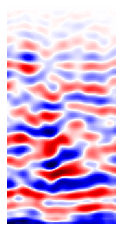

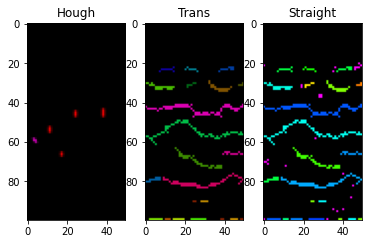


средняя амплитуда  =  0.28946
среднеквадратичная амплитуда  =  0.005821
частота максимума спектра  =  35.0
энергия спектра  =  0.06396
ширина спектра  =  27.63312
центральная частота  =  60.0
доля важной энергии спектра  =  0.76206
временная разреженность  =  0.245
динамическая выраженность  =  0.48978
индекс полосы пропускания  =  0.70343
доминантная частота  =  35.20833
максимальная длина линий Хафа  =  4.0
средняя длина линий Хафа  =  2.70601
среднее угла линии Хафа (обратная величина)  =  -0.02905
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.02142
стандартное отклонение угла линии Хафа (обратная величина)  =  0.01266
максимальная длина контура  =  134.92388
средняя длина контура  =  15.76369
максимальная спрямлённость  =  0.875
средняя спрямлённость  =  0.34385



array([[ 2.8946000e-01,  5.8210000e-03,  3.5000000e+01,  6.3960000e-02,
         2.7633120e+01,  6.0000000e+01,  7.6206000e-01,  2.4500000e-01,
         4.8978000e-01,  7.0343000e-01,  3.5208330e+01,  4.0000000e+00,
         2.7060100e+00, -2.9050000e-02, -2.1420000e-02,  1.2660000e-02,
         1.3492388e+02,  1.5763690e+01,  8.7500000e-01,  3.4385000e-01]])

In [ ]:
create_features1('', objects[12], draw=True, save=False)



> 



#####Создание матрицы  features2, картиночных признаковых описаний

In [ ]:
way = '/content/drive/My Drive/Colab Notebooks/Second_features/'

In [ ]:
features2, pict_bw, pict_str = create_features2('features2', objects[:])

In [ ]:
features2.shape, pict_bw.shape, pict_str.shape

((17080, 5571), (17080, 100, 50), (17080, 100, 50, 3))

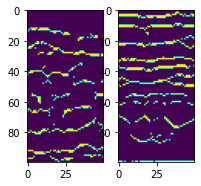

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3, 6))           
a1 = ax1.imshow(pict_bw[0])
a2 = ax2.imshow(pict_bw[1])
plt.show()

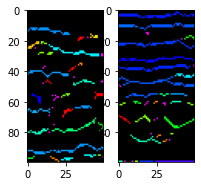

In [ ]:
pict_str = pict_str.astype(np.uint8)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3, 6))           
a1 = ax1.imshow(pict_str[0])
a2 = ax2.imshow(pict_str[1])
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

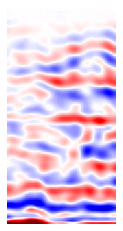

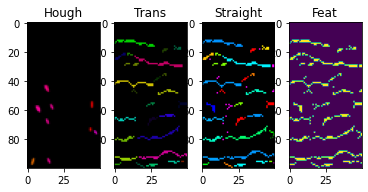

 50%|█████     | 1/2 [00:00<00:00,  1.98it/s]


средняя амплитуда  =  0.3628369254346844
среднеквадратичная амплитуда  =  0.07003177545410137
частота максимума спектра  =  25.0
энергия спектра  =  0.13477564125601793
ширина спектра  =  19.379246270956138
центральная частота  =  40.0
доля важной энергии спектра  =  0.5781776494463498
временная разреженность  =  0.09100000000000001
динамическая выраженность  =  0.5187951391341029
индекс полосы пропускания  =  0.6042582500583327
доминантная частота  =  32.125
максимальная длина линий Хафа  =  4.47213595499958
средняя длина линий Хафа  =  3.3146429849933345
среднее угла линии Хафа (обратная величина)  =  0.020706956065727325
взвешенное среднее угла линии Хафа (обратная величина)  =  0.023551197213108842
стандартное отклонение угла линии Хафа (обратная величина)  =  0.017737934429938207
максимальная длина контура  =  72.87005710601807
средняя длина контура  =  15.66403217648351
максимальная спрямлённость  =  0.8214285714285714
средняя спрямлённость  =  0.3281616379551424
число контуров 

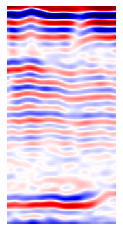

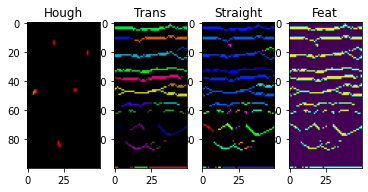

100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


средняя амплитуда  =  0.5366212687249895
среднеквадратичная амплитуда  =  0.11371501333859037
частота максимума спектра  =  85.0
энергия спектра  =  0.532211266003216
ширина спектра  =  25.699825036309605
центральная частота  =  160.0
доля важной энергии спектра  =  0.9265196400086958
временная разреженность  =  0.4866666666666667
динамическая выраженность  =  0.32654206505602074
индекс полосы пропускания  =  0.5964860518669236
доминантная частота  =  61.66666666666666
максимальная длина линий Хафа  =  4.0
средняя длина линий Хафа  =  2.6846975177964865
среднее угла линии Хафа (обратная величина)  =  -0.014716761791680886
взвешенное среднее угла линии Хафа (обратная величина)  =  -0.01730489038502187
стандартное отклонение угла линии Хафа (обратная величина)  =  0.017813186171096066
максимальная длина контура  =  129.49747383594513
средняя длина контура  =  24.246982124447822
максимальная спрямлённость  =  0.9615384615384616
средняя спрямлённость  =  0.44312280981429913
число контуров

In [ ]:
features2, pict_bw, pict_str = create_features2('features2', objects[0:2], draw=True, save=False)

######Состыковка массивов

In [ ]:
a = np.array([[0,1],[1,0],[4,5]])
a

array([[[0, 1],
        [1, 0],
        [4, 5]]])

In [ ]:
b = np.array([[0,1],[1,0],[4,5]])*2
b

array([[[ 0,  2],
        [ 2,  0],
        [ 8, 10]]])

In [ ]:
a = a[np.newaxis, :] # чтобы получилось раз за разом состыковывать массивы, надо добавить дополнительную ось, вдоль которой будет состыкование
a

array([[[[0, 1],
         [1, 0],
         [4, 5]]]])

In [ ]:
b = b[np.newaxis, :]
b

array([[[[ 0,  2],
         [ 2,  0],
         [ 8, 10]]]])

In [ ]:
ab = np.vstack((a,b))
ab

array([[[ 0,  1],
        [ 1,  0],
        [ 4,  5]],

       [[ 0,  2],
        [ 2,  0],
        [ 8, 10]]])

In [ ]:
c = np.array([[[2,1],[1,2],[4,5]]])*0.23
c

array([[[0.46, 0.23],
        [0.23, 0.46],
        [0.92, 1.15]]])

In [ ]:
abc = np.vstack((ab,c)) # если ось не добавить, то здесь не пройдёт
abc

array([[[ 0.  ,  1.  ],
        [ 1.  ,  0.  ],
        [ 4.  ,  5.  ]],

       [[ 0.  ,  2.  ],
        [ 2.  ,  0.  ],
        [ 8.  , 10.  ]],

       [[ 0.46,  0.23],
        [ 0.23,  0.46],
        [ 0.92,  1.15]]])

In [ ]:
abc.shape

(3, 3, 2)

In [ ]:
ab.shape

(2, 3, 2)

In [ ]:
a.shape

(1, 3, 2)



> 



###**Масштабирование признаков**

*Можно не только масштабировать, но и трансформировать к какому-либо распределению, но к какому?*

In [ ]:
np.where(np.isinf(features1) == True) # проверка на некорректные признаки

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
np.where(np.isnan(features1) == True) # проверка на некорректные признаки

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
np.std(features1, axis = 0) # дисперсии признаков

array([1.08135619e+03, 1.98971862e+01, 1.57574708e+01, 7.64488199e+06,
       7.30130711e+00, 2.64294885e+01, 2.80575879e-01, 2.74223304e-01,
       1.16490578e-01, 2.00245429e-01, 9.70917047e+00, 3.53076796e+00,
       1.32041404e+00, 4.44000637e+12, 2.54817850e+12, 2.46643958e+12,
       3.36682722e+01, 1.27048079e+01, 8.49765467e-02, 2.93494487e-01])

In [ ]:
#features = VarianceThreshold(0.07).fit_transform(features1) # с дисерсией ниже вводимого числа признак будет выкинут

In [ ]:
X = (features1 - np.mean(features1, axis = 0)) / np.std(features1, axis = 0) # X - признаки с нулевым средним и единичной дисперсией



> 



###**Уменьшение размерности признаков**

*Какой сделать финальную размерность?*

In [ ]:
def reduce_pca(var_name, data, dim):
# снижает размерность признаков data до dim
# var_name - для сохранения

  pca = PCA(n_components = dim)
  data_pca = pca.fit_transform(data)
  
  name_file = '{0}.npy'.format(var_name)
  np.save(way + name_file, data_pca)

  return data_pca

*Существуют ещё методы понижения размерности, вдруг они отработают лучше + isomap тоже надо подстроить*

In [ ]:
def reduce_isomap(var_name, data, dim, n_neighbors):
# снижает размерность признаков data до dim
# n_neighbors - число соседей, которые нужно учитывать для каждой точки
# var_name - для сохранения

  iso = Isomap(n_components=dim, n_neighbors=n_neighbors, n_jobs=-1, p=1)
  data_iso = iso.fit_transform(data)

  name_file = '{0}__neighbors={1}.npy'.format(var_name, n_neighbors)
  np.save(way + name_file, data_iso)

  return data_iso

*Можно ещё очень долго оптимизировать архитектуру сетки автоэнкодера и его гиперпараметры (+ в одной из статей каждый его слой предобучали ограниченной машиной Больцмана (надо попробовать)), чтобы меньше была ошибка; в теории должен превзойти (по крайней мере по быстроте) методы из sklearn*

In [ ]:
def reduce_autoencoder(var_name, data, dim):
# снижает размерность признаков data до dim
# var_name - для сохранения

  x_train, x_test = train_test_split(data, test_size = 0.15, random_state=32, shuffle = True) # shuffle = True - перемешиваем выборку
  
  # изменением гиперпараметров (см. Autoencoders for seismic) была подобрана следующая модель:
  # encoder
  input_attrs = Input(shape = (20,))
  x = Dense(19, activation='tanh', bias_initializer='zeros', kernel_initializer='random_uniform')(input_attrs)
  x = Dense(17, activation='tanh', bias_initializer='zeros', kernel_initializer='random_uniform')(x)
  code = Dense(dim, activation='linear')(x)
  
  # decoder
  input_code = Input(shape = (dim,))
  x = Dense(17, activation='tanh', bias_initializer='zeros', kernel_initializer='random_uniform')(input_code)
  x = Dense(19, activation='tanh', bias_initializer='zeros', kernel_initializer='random_uniform')(x)
  out_attrs = Dense(20, activation='linear')(x)

  encoder = Model(input_attrs, code, name="encoder")
  decoder = Model(input_code, out_attrs, name="decoder")
  d_ae = Model(input_attrs, decoder(encoder(input_attrs)), name="autoencoder")

  l_rate = 0.0005 # скорость обучения
  d_ae.compile(Adam(l_rate), loss='mse', metrics=['mae']) # две метрики качества модели: средняя квадратичная ошибка (по ней обучается) и средняя абсолютная

  # stop training when a monitored quantity has stopped improving
  # patience - сколько эпох терпеть не улучшения качества (здесь не уменьшения val_loss)
  # restore_best_weights=True - сохранятся веса с лучшим качеством (здесь с минимальным val_loss)
  # обычно добавляется как callback в model.fit, но мы используем scikit-learn API; чтобы не было проблем, надо добавить earlyStopping в GridSearchCV_object.fit, причём как-то хитро (см. ниже)
  earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

  epo = 2000 # возможно можно > 2000

  hist = d_ae.fit(x_train, # shape[0] у подаваемых объектов должен быть их числом
                x_train, 
                epochs=epo, # в конце каждой эпохи проводится мониторинг функции потерь (val_loss) на validation_data (эпоха - отработать все объекты (случайно выбирается в течение эпохи количество объектов = количеству объектов в тренировочной выборке))
                batch_size=70, # сколько объектов будет накоплено (в сумму функционала ошибки) для одного обновления градиента (по умолчанию 32)
                shuffle=True, # перемешивать ли тренировочные данные в конце каждой эпохи
                verbose=1, # показ progress bar
                validation_data=(x_test, x_test), # данные для контроля переобучения
                callbacks = [earlyStopping])
  
  # графики обучения
  N = np.arange(0, len(hist.history["loss"]))
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

  ax1.plot(N, hist.history["loss"], label="train_loss")
  ax1.plot(N, hist.history["val_loss"], label="val_loss")

  ax1.set_title("Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("MSE")
  ax1.legend()

  fig = plt.figure()
  ax2.plot(N, hist.history["mae"], label="train_metrics")
  ax2.plot(N, hist.history["val_mae"], label="val_metrics")

  ax2.set_title("Metrics")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MAE")
  ax2.legend()

  print()
  print('loss и metrics на тестовых данных', d_ae.evaluate(x_test, x_test))

  name_file = '{0}.npy'.format(var_name)
  d_ae.save(way + name_file)

  data_autoen = d_ae.get_layer(name="encoder").predict(data)

  return data_autoen



> 



###**Кластеризация**

*Хоть optics позиционируется как алгоритм, проще настраиваемый чем dbscan, но надо всё равно надо возиться с настройкой + можно попробовать ещё методы*

In [ ]:
def clust_optics(var_name, data, min_samples, xi, min_cluster_size):
# кластеризация данных data через optics; параметры см. ниже
# var_name - для сохранения

  # Unlike DBSCAN, the OPTICS algorithm does not produce a strict cluster partition, 
  # but an augmented ordering of the database. To produce the cluster partition, you can use OPTICSxi (already in OPTICS method in sklearn), 
  # which is algorithm that produces a classification based on the output of OPTICS.
  # Parametr 'xi' controls directly the number of classes we will obtain.
  # cluster_optics_dbscan in sklearn is another way to produce clusters from output of OPTICS.

  # по сути главное отличие от dbscan, что optics использует range of epsilons; 
  # чем меньше epsilon, тем меньше кластеры, тем их больше; увеличивая epsilon, кластеры сливаются (так в dbscan);
  # поэтому, если работать с range of epsilons, можно получить иерархическое разбиение на кластеры

  optics = OPTICS(
  # по сути для построения графика reachability:
               min_samples=min_samples, # число соседних точек, которые сделают данную точку корневым объектом (требующихся для образования нового кластера)
               max_eps=np.inf, # максимальная окрестность рассматриваемой точки, в которой все попавшие остальные точки считаются соседями рассматриваемой точки
               metric='minkowski', # функция измерения расстояния
               p=1, # параметр для метрики Минковского (лучшая метрика для многомерных пространств)
  # работают с выходом OPTICS, чтобы извлечь кластеры (извлечь из графика reachability):
               cluster_method='xi', # метод извлечения кластеров из выхода алгоритма OPTICS (ещё можно через 'dbscan' (см. ниже))
               xi=xi, # it is relative decrease in density (для отделения кластеров друг от друга)
               min_cluster_size=min_cluster_size) # размер минимального кластера = подаваемая доля от общего числа точек или число точек
  
  optics.fit(data)


  name_file = '{0}__min_samples={1}_xi={2}_min_cluster_size={3}.pkl'.format(var_name, min_samples, xi, min_cluster_size)
  with open(way + name_file,'wb') as f:
    pickle.dump(optics, f)

  return optics

In [ ]:
def reachability_plot(optics, labels_cluster_oder=[], limx=[0, 0], limy=[0, 0], title=''):
# рисуем график расстояния достижимости, раскрашиваем на нём найденные кластеры, limx limy - масштаб по осям
# title - заголовок графика
# labels_cluster_oder - сюда подаются метки объектов, соответствующих участкам графика достижимости без впадин (метки объектов вне кластеров) (см. ячейку ниже)

  labels = optics.labels_

  if len(labels_cluster_oder) == 0:
    num_clust = np.unique(labels).shape[0]
  else:
    num_clust = np.unique(labels_cluster_oder).shape[0]

  if num_clust > 1000:
    print('too many clusters')
    return
  
  space = np.arange(labels.shape[0])

  if len(labels_cluster_oder) == 0:
    labels_cluster_oder = labels[optics.ordering_]
  reachability_cluster_oder = optics.reachability_[optics.ordering_]

  colors_array = np.random.rand(num_clust, 3)
  colors_tuple = list(map(tuple, colors_array[:]))

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
  for cluster, color in zip(range(0, num_clust), colors_tuple):
    x_k = space[labels_cluster_oder == cluster]
    r_k = reachability_cluster_oder[labels_cluster_oder == cluster]
    ax.scatter(x_k, r_k, c=[color], s=7, alpha=1, marker='1')
    #ax.plot(x_k, r_k, c=[color], marker='1')
  ax.scatter(space[labels_cluster_oder == -1], reachability_cluster_oder[labels_cluster_oder == -1], c='black', s=0.1, alpha=0.7, marker='2')
  #ax.plot(pace[labels_cluster_oder == -1], reachability_cluster_oder[labels_cluster_oder == -1], c='black', alpha=0.07, marker='2')
  
  plt.title(title)

  if limx[0] != limx[1]:
    ax.set_xlim(limx[0], limx[1])
  if limy[0] != limy[1]:
    ax.set_ylim(limy[0], limy[1])

*Ведь можно искусственно повыделять впадины и промежуточные линии графика расстояния достижимости в отдельные кластеры? Видимо да, потом их вновь можно кластеризовать*

In [ ]:
def heavy_clusters(optics):
# возвращает метки объектов на линиях между минимумами на графике достижимости (т.е. метки объектов вне кластеров) 
# в порядке их следования по графику достижимости
# (как будто эти линии кластеры)

  num_clust = np.unique(optics.labels_).shape[0]
  labels_cluster_oder = optics.labels_[optics.ordering_]

  clust_id = np.arange(num_clust - 1)

  cl_limits = [0]
  for cl_id in clust_id:
    obj_in_cl = np.where(labels_cluster_oder == cl_id)[0] # np.where возвращает tuple с массивом

    cl_start = obj_in_cl[0]
    cl_limits.append(cl_start)

    cl_end = obj_in_cl[len(obj_in_cl) - 1]
    cl_limits.append(cl_end)

  cl_limits.append(len(labels_cluster_oder)-1)
  cl_limits = np.array(cl_limits)

  cl_limits_ = cl_limits

  labels_new = np.arange(optics.labels_.shape[0])
  st = 0
  end = 1
  cl_id = 0
  while end != len(cl_limits):
    if cl_id % 2 == 0:
      labels_new[cl_limits[st]:cl_limits[end]+1] = int(cl_id/2)
    else:
      labels_new[cl_limits[st]:cl_limits[end]+1] = -1

    cl_id += 1  
    st += 1
    end += 1
    
  return labels_new

*Существуют способы оценки качества кластеризации (это тоже сделаю), но это как бы с геометрической точки зрения. А как показать, что одна кластеризация лучше другой именно по качеству сейсмических данных?*

In [ ]:
def visualize_clusters(data, labels):
# отображает объекты (разрезы) по кластерам; если больше 100 объектов в кластере, то отображает случайные 100 объектов

    num_clust = np.unique(labels).shape[0] # метку -1 тоже считаем
    
    for i in range(-1, num_clust - 1):
        
        data_in_clust = data[labels == i]
        num_in_clust = data_in_clust.shape[0]
        
        if num_in_clust <= 100:
            visualize_objects(data_in_clust, title="Cluster {0} with {1} objects".format(i, num_in_clust))
        else:   
            ind_for_imshow = np.random.randint(0, num_in_clust, size=100)
            visualize_objects(data_in_clust[ind_for_imshow], title="Cluster {0} with {1} objects".format(i, num_in_clust))



> 



###**Визуализация двумерных данных**

In [ ]:
def draw_samples_2D(data, limx=[0, 0], limy=[0, 0]):
# рисуем точки data, limx limy - масштаб по осям

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.scatter(data[:, 0], data[:, 1], s=0.05, color='black')

  #plt.tick_params(axis='both', which='major', labelsize=28)
  #plt.show()
  if limx[0] != limx[1]:
    ax.set_xlim(limx[0], limx[1])
  if limy[0] != limy[1]:
    ax.set_ylim(limy[0], limy[1])

In [ ]:
def draw_clusters_2D(data, labels, limx=[0, 0], limy=[0, 0]):
# рисует точки data и раскрашивает их по кластерам labels, limx limy - масштаб по осям

  num_clust = np.unique(labels).shape[0]
  if num_clust > 1000:
    print('too many clusters')
    return

  colors_array = np.random.rand(num_clust, 3)
  colors_tuple = list(map(tuple, colors_array))

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  for cluster, color in zip(range(0, num_clust), colors_tuple):
    cl_data = data[labels == cluster]
    ax.scatter(cl_data[:,0], cl_data[:,1], c=[color], s=5)
  ax.scatter(data[labels == -1, 0], data[labels == -1, 1], c='black', marker='1', s=0.05)

  if limx[0] != limx[1]:
    ax.set_xlim(limx[0], limx[1])
  if limy[0] != limy[1]:
    ax.set_ylim(limy[0], limy[1])



> 

